# import


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

import torch
import torch.nn as nn
from torch.nn import RNN, Module
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# RNN
* `nn.RNN(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, ...)`
* input shape
  * batch_first=False : L, N, H,
  * batch_first=True : N, L, H
    * L : sequence_length
    * N : batch_size
    * H : intput_size(feature_size)

## Many To Many
* 다음 수 예측


In [ ]:
seq_len = 4
batch_size = 5

x = [ [[i/10] for i in range(j, j+seq_len)] for j in range(batch_size)]
y = [ [[i/10] for i in range(j+1, j+seq_len+1)] for j in range(batch_size)]
display("x", np.shape(x), x)
display("y", np.shape(y), y)

x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

'x'

(5, 4, 1)

[[[0.0], [0.1], [0.2], [0.3]],
 [[0.1], [0.2], [0.3], [0.4]],
 [[0.2], [0.3], [0.4], [0.5]],
 [[0.3], [0.4], [0.5], [0.6]],
 [[0.4], [0.5], [0.6], [0.7]]]

'y'

(5, 4, 1)

[[[0.1], [0.2], [0.3], [0.4]],
 [[0.2], [0.3], [0.4], [0.5]],
 [[0.3], [0.4], [0.5], [0.6]],
 [[0.4], [0.5], [0.6], [0.7]],
 [[0.5], [0.6], [0.7], [0.8]]]

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

class NextNumberM2M(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) #input_size, hidden_size, n_layer=1
    self.fc = nn.Linear(hidden_size, output_size) # 32 * seq_len

  def forward(self, x):
    x, h= self.rnn(x)
    x = self.fc(x)
    return x

In [ ]:
#input_size, hidden_size, output_size
model = NextNumberM2M(1, 32, 1)
output = model(x)
output.shape

torch.Size([5, 4, 1])

In [ ]:
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters())

losses = []
for epoch in range(1000):
  output = model(x)
  opt.zero_grad()
  cost = loss_fn(output, y)
  cost.backward()
  opt.step()

  if epoch%100==0:
    print(f'epoch={epoch}, cost:{cost.item()}')
  losses.append(cost.item())

epoch=0, cost:0.2479788064956665
epoch=100, cost:0.010503732599318027
epoch=200, cost:0.0035929507575929165
epoch=300, cost:0.0024054027162492275
epoch=400, cost:0.0016623437404632568
epoch=500, cost:0.001153325429186225
epoch=600, cost:0.0007541654049418867
epoch=700, cost:0.0004485029785428196
epoch=800, cost:0.00023376746685244143
epoch=900, cost:0.0001025596066028811


In [ ]:
pred = model(x).detach().numpy()
print(f'pred: {pred.reshape(-1, 4)}')
print(f'round:{np.around(pred.reshape(-1, 4), 1)}')

pred: [[0.11698695 0.19674805 0.29877514 0.39769232]
 [0.20889658 0.29927945 0.4008466  0.5007172 ]
 [0.30070758 0.40093058 0.5016182  0.6019354 ]
 [0.39217407 0.5015364  0.6008695  0.70114577]
 [0.48305362 0.60094446 0.6984038  0.7981818 ]]
round:[[0.1 0.2 0.3 0.4]
 [0.2 0.3 0.4 0.5]
 [0.3 0.4 0.5 0.6]
 [0.4 0.5 0.6 0.7]
 [0.5 0.6 0.7 0.8]]


## Many To One

In [ ]:
seq_size = 4
batch_size = 5

x = [ [[i/10] for i in range(j, j+seq_size)] for j in range(batch_size)]
y = [[ (i+seq_size) /10] for i in range(batch_size)]
display("x", np.shape(x), x, "y", np.shape(y), y)

x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

'x'

(5, 4, 1)

[[[0.0], [0.1], [0.2], [0.3]],
 [[0.1], [0.2], [0.3], [0.4]],
 [[0.2], [0.3], [0.4], [0.5]],
 [[0.3], [0.4], [0.5], [0.6]],
 [[0.4], [0.5], [0.6], [0.7]]]

'y'

(5, 1)

[[0.4], [0.5], [0.6], [0.7], [0.8]]

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

class NextNumberM2M(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.rnn = nn.RNN(input_size, hidden_size) #input_size, hidden_size, n_layer=1
    self.fc = nn.Linear(32, output_size) # 32 * seq_len

  def forward(self, x):
    x, h= self.rnn(x)
    x = x[:,-1, :] # Many to One
    x = self.fc(x)
    return x

In [ ]:
model = NextNumberM2M(1, 32, 1)
output = model(x)
output.shape

torch.Size([5, 1])

In [ ]:
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters())

losses = []
for epoch in range(1000):
  output = model(x)
  opt.zero_grad()
  cost = loss_fn(output, y)
  cost.backward()
  opt.step()

  if epoch%100==0:
    print(f'epoch={epoch}, cost:{cost.item()}')
  losses.append(cost.item())

epoch=0, cost:0.39046409726142883
epoch=100, cost:0.0028547984547913074
epoch=200, cost:0.000227966665988788
epoch=300, cost:2.2824304323876277e-05
epoch=400, cost:2.016314510910888e-06
epoch=500, cost:9.503328612936457e-08
epoch=600, cost:2.4093438355521357e-09
epoch=700, cost:3.354276925660038e-11
epoch=800, cost:3.1992187761800683e-13
epoch=900, cost:1.509903313490213e-14


In [ ]:
pred = model(x).detach().numpy()
print(f'pred: {pred}')
print(f'round:{np.around(pred, 1)}')

pred: [[0.39999986]
 [0.5       ]
 [0.6       ]
 [0.70000005]
 [0.79999995]]
round:[[0.4]
 [0.5]
 [0.6]
 [0.7]
 [0.8]]


# RNN Regression
* LSTM, GRU, 주식가격 예측

## stock 데이터

In [3]:
import os
os.environ["HTTP_PROXY"] = "70.10.15.10:8080"
os.environ['HTTPS_PROXY'] = "70.10.15.10:8080"
os.environ['CURL_CA_BUNDLE'] = ''
os.environ['PYTHONHTTPSVERIFY'] ='0' 

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# 강사가 파일을 제공한 경우 실행하지 마세요.
from urllib import request

url_stock = 'https://raw.githubusercontent.com/dltpdn/download/master/csv/stock.csv'
file_stock = 'stock.csv'
with request.urlopen(url_stock) as r:
  with open(file_stock, 'wb') as f:
    f.write(r.read())

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

seq_length = 7 # train with 7days features for next day close price
data_dim = 5 # 5 features

url_stock = 'https://raw.githubusercontent.com/dltpdn/download/master/csv/stock.csv'
df = pd.read_csv(url_stock, header=1)
display(df)
values = df.values[::-1]  # resverse because the data is fliped

scaler = StandardScaler() # normalize
values_scaled = scaler.fit_transform(values)
X,y = [],[]
for i in range(0, len(values) - seq_length):
    start, end = i, i+seq_length
    X.append(values_scaled[start: end]) # 5 features data of 7 days for input
    y.append(values_scaled[end, -1:])    # 8th close price
X,y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


,# Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012
...,...,...,...,...,...
727,599.992707,604.832763,562.192568,147100,567.002574
728,558.712504,568.452595,558.712504,7900,567.162558
729,566.892592,567.002574,556.932537,10800,556.972503
730,561.202549,566.432590,558.672539,41200,559.992565


((507, 7, 5), (218, 7, 5), (507, 1), (218, 1))

## Dataset, DataLoader

In [ ]:
train_ds = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_ds =  TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds)

## 모델 정의

In [ ]:
import torch.nn.functional as F

class StockPrice(nn.Module):
  def __init__(self, input_size, output_size):
    super(StockPrice, self).__init__()
    self.rnn = nn.GRU(input_size, 64, batch_first=True)
    self.fc1 = nn.Linear(64, 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, output_size)

  def forward(self, x):
    x, _ = self.rnn(x)
    x = self.fc1(x[:, -1, :])
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

## 학습, 평가 함수 정의

In [ ]:
def fit(model, loader, loss_fn, opt):
  n_batch = len(loader)
  loss=0
  model.train()
  for (x, y) in loader:
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    cost = loss_fn(y_pred, y)
    opt.zero_grad()
    cost.backward()
    opt.step()
    loss += cost.item()/n_batch
  return loss

def evaluate(model, loader, metric_fn):
  loss=0
  n_batch = len(loader)
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      y_pred = model(x)
      cost = metric_fn(y_pred, y)
      loss += cost.item()/n_batch
  return loss

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = StockPrice(5, 1).to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters())

train_losses = []
val_losses = []
for epoch in range(200):
  train_loss = fit(model, train_loader, loss_fn, opt)
  val_loss = evaluate(model, test_loader, loss_fn)
  if epoch%10==0:
    print(f'epoch={epoch}, cost:{train_loss}, val_cost:{val_loss}')
  train_losses.append(train_loss)
  val_losses.append(val_loss)


epoch=0, cost:0.4361916051711887, val_cost:0.9262568871896513
epoch=10, cost:0.013488620781572536, val_cost:0.040164806022712086
epoch=20, cost:0.011115845954918768, val_cost:0.023084294134883918
epoch=30, cost:0.009566560496750753, val_cost:0.019642279585746148
epoch=40, cost:0.008997542150609661, val_cost:0.02606787499480208
epoch=50, cost:0.008023088827030733, val_cost:0.011141963139674811
epoch=60, cost:0.0077610061889572535, val_cost:0.010033615823521537
epoch=70, cost:0.007358341499639209, val_cost:0.009964256834677533
epoch=80, cost:0.006835471074737143, val_cost:0.010689306571094126
epoch=90, cost:0.006753365785698406, val_cost:0.008812599708199994
epoch=100, cost:0.006260119906073669, val_cost:0.00887237118120386
epoch=110, cost:0.005989888544718269, val_cost:0.010490139832226592
epoch=120, cost:0.005784099696029443, val_cost:0.012458797062157273
epoch=130, cost:0.004684921204898274, val_cost:0.008712368066574449
epoch=140, cost:0.004779114937264239, val_cost:0.011622196034361

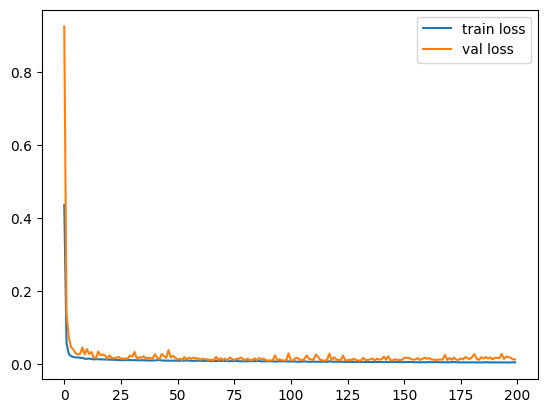

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend();

## 추론

### 추론 함수 정의

In [ ]:
def predict(model, loader):
  preds = []
  model.eval()
  with torch.no_grad():
    for X, y in loader:
      X = X.to(device)
      y_pred = model(X)
      preds.append(y_pred.detach().cpu().numpy())
  return np.concatenate(preds)

### Train data 추론 및 비교

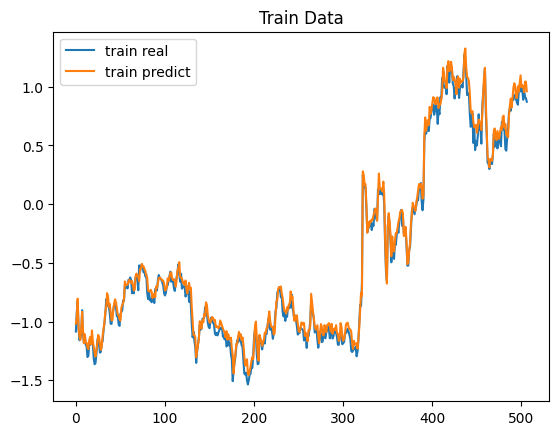

In [ ]:
outputs_train = predict(model, DataLoader(train_ds))
plt.plot(y_train, label='train real')
plt.plot(outputs_train, label='train predict')
plt.title("Train Data")
plt.legend();

### Test data 추론 및 비교

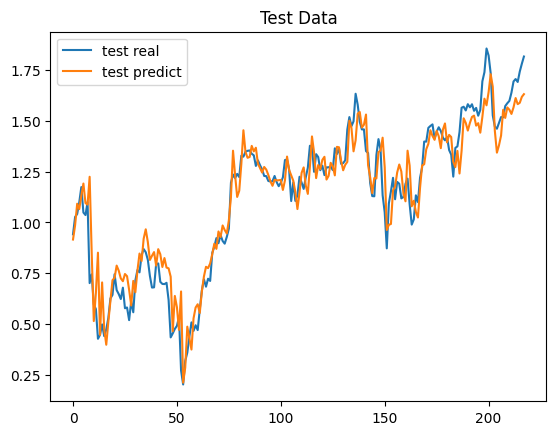

In [ ]:
outputs_test = predict(model, test_loader)
plt.plot(y_test, label='test real')
plt.plot(outputs_test, label='test predict')
plt.title("Test Data")
plt.legend();

## 평가

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_train = mean_absolute_error(y_train, outputs_train)
rmse_train = mean_squared_error(y_train, outputs_train, squared=False)
r2_train = r2_score(y_train, outputs_train)

mae_test = mean_absolute_error(y_test, outputs_test)
rmse_test = mean_squared_error(y_test, outputs_test, squared=False)
r2_test = r2_score(y_test, outputs_test)
print(f'train mae:{mae_train}, rmse:{rmse_train}, r2:{r2_train} ')
print(f'test mae:{mae_test}, rmse:{rmse_test}, r2:{r2_test} ')


train mae:0.052895548181730666, rmse:0.06779702975708772, r2:0.9924542499753896 
test mae:0.07908635793077799, rmse:0.1074929773186915, r2:0.9171772241099204 


# RNN Classification
* MNIST

## Dataset

### MNIST Dataset

In [6]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

mnist_train = dsets.MNIST(root='.', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='.', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)
mnist_train.data.shape, mnist_test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
for X, y in mnist_train:
  print(X.shape)
  break

<class 'torch.Tensor'>
torch.Size([1, 28, 28])


### Custom Data Transformations
* Squeeze

In [ ]:
class Squeeze():
  def __call__(self, sample):
    return torch.squeeze(sample)

mnist_train = dsets.MNIST(root='.', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.Compose([
                              transforms.ToTensor(), # 텐서로 변환
                              Squeeze()]), # squeeze
                          download=True)

mnist_test = dsets.MNIST(root='.', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.Compose([
                              transforms.ToTensor(), # 텐서로 변환
                              Squeeze()]), # squeeze
                         download=True)
mnist_train.data.shape, mnist_test.data.shape

for X, y in mnist_train:
  print(X.shape)
  break

torch.Size([28, 28])


### DataLoader

In [ ]:
batch_size=64
train_loader = DataLoader(dataset=mnist_train,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=mnist_test,
                         batch_size=batch_size)

In [ ]:
for X, y in train_loader:
  print(X.shape, torch.squeeze(X).shape)
  print(X.max(), X.min(), y.max(), y.min())
  break

torch.Size([64, 28, 28]) torch.Size([64, 28, 28])
tensor(1.) tensor(0.) tensor(9) tensor(0)


## 모델 정의

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

class MNISTClassifier(nn.Module):
  def __init__(self, input_size, seq_len, output_size):
    super().__init__()
    hidden_size = 128
    self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x, _ = self.rnn(x)
    x = self.fc(x[:, -1, :])
    return x

## 모델 학습

In [ ]:
def fit(model, loader, loss_fn, opt):
  n_batch = len(loader)
  loss=0
  model.train()
  for (x, y) in loader:
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    cost = loss_fn(y_pred, y)
    opt.zero_grad()
    cost.backward()
    opt.step()
    loss += cost.item()/n_batch
  return loss

def evaluate(model, loader, metric_fn):
  loss=0
  n_batch = len(loader)
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      y_pred = model(x)
      cost = metric_fn(y_pred, y)
      loss += cost.item()/n_batch
  return loss

In [ ]:
model = MNISTClassifier(28, 28, 10).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

history={'train_loss' :[], 'val_loss': []}
for epoch in range(10):
  train_loss = fit(model, train_loader, loss_fn, opt)
  val_loss = evaluate(model, test_loader, loss_fn)
  print(f'epoch={epoch}, cost:{train_loss} , val_cost:{val_loss}')
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)


epoch=0, cost:0.34345814442115125 , val_cost:0.11356567811209026
epoch=1, cost:0.10028005593137612 , val_cost:0.07776127364649582
epoch=2, cost:0.08602869801192484 , val_cost:0.07447925952387749
epoch=3, cost:0.07388707620279403 , val_cost:0.07170677211752553
epoch=4, cost:0.07213480722482829 , val_cost:0.08721212707133669
epoch=5, cost:0.06373146063224207 , val_cost:0.06260816670307641
epoch=6, cost:0.05937553655447013 , val_cost:0.07348987685885745
epoch=7, cost:0.06807283323463195 , val_cost:0.07886833686323746
epoch=8, cost:0.06245706268392103 , val_cost:0.07513004028687709
epoch=9, cost:0.06335129722608306 , val_cost:0.07469441320607734


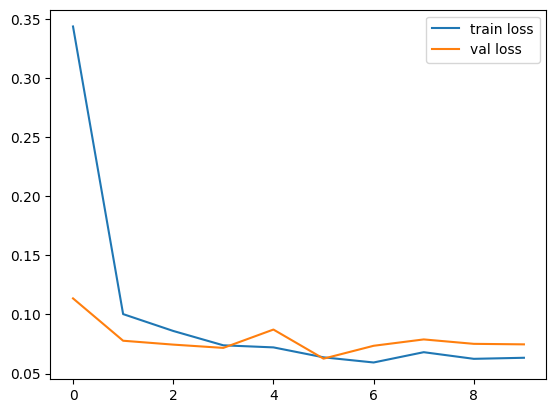

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend();

## 평가

In [ ]:
def predict(model, loader, fn=None, **kw):
  preds = []
  model.eval()
  with torch.no_grad():
    for X, y in loader:
      X = X.to(device)
      y_pred = model(X)
      if fn:
        y_pred = fn(y_pred, **kw)
      preds.append(y_pred.detach().cpu().numpy())
  return np.concatenate(preds)


proba_train = predict(model, DataLoader(mnist_train, shuffle=False), F.softmax, dim=1)
proba_test = predict(model, DataLoader(mnist_test, shuffle=False), F.softmax, dim=1)
pred_train = np.argmax(proba_train, axis=1)
pred_test = np.argmax(proba_test, axis=1)
train_acc = accuracy_score(mnist_train.targets.numpy(), pred_train)
test_acc = accuracy_score(mnist_test.targets.numpy(), pred_test)

print(f'train acc:{train_acc}, test acc:{test_acc}')

train acc:0.9818666666666667, test acc:0.9778
